In [1]:
import numpy as np
import networkx as nx
import json
from networkx.readwrite import json_graph

In [2]:
from matplotlib import pyplot as plt

In [3]:
from bokeh.io import show, output_file, output_notebook
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, BoxZoomTool, ResetTool
from bokeh.models.graphs import from_networkx
from bokeh.palettes import Spectral4

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=True)

In [5]:
import os

In [6]:
graph_data = json.load(open("/home/gear/data/ppi/ppi-G.json"))

In [7]:
G = json_graph.node_link_graph(graph_data)

In [8]:
len(G)

56944

### Get the number connected components and a mapping for separated graphs

In [10]:
num_connected_components = nx.number_connected_components(G)
connected_components_subgraphs = nx.connected_component_subgraphs(G)

print("Number of connected components: ", num_connected_components)

('Number of connected components: ', 295)


In [11]:
type(connected_components_subgraphs)

generator

In [12]:
connected_components_subgraphs = [g for g in connected_components_subgraphs]

In [13]:
connected_components_subgraphs[0].node[0]

{u'test': False, u'val': False}

In [14]:
test_graphs = []
val_graphs = []
train_graphs = []
for i, g in enumerate(connected_components_subgraphs):
    test = 'not set'
    val = 'not set'
    for node_id in g.nodes():
        if test == 'not set' and val == 'not set':
            test = str(g.node[node_id]['test'])
            val = str(g.node[node_id]['val'])
        if str(g.node[node_id]['test']) != test or str(g.node[node_id]['val']) != val:
            print("Inconsistent in val-test marker for graph index {}".format(i))
    if test == 'True' and val == 'False':
        test_graphs.append(g)
    if test == 'False' and val == 'True':
        val_graphs.append(g)
    if test == 'False' and val == 'False':
        train_graphs.append(g)
    if test == 'True' and val == 'True':
        print("Something is really wrong.")

The cell above doesn't print val-test warning means that the data is correct: Each whole connected component is a test/val/train.

In [15]:
len(test_graphs)

30

In [16]:
len(val_graphs)

30

In [17]:
len(train_graphs)

235

In [18]:
print(sum(g.size() for g in test_graphs))

83331


In [19]:
print(sum(g.size() for g in val_graphs))

102187


In [20]:
print(sum(g.size() for g in train_graphs))

633198


In [21]:
for i, tg in enumerate(test_graphs):
    if len(tg) > 1:
        print(i, len(tg))

(0, 3194)
(8, 2)
(15, 2)
(19, 2300)


In [62]:
test_graphs = test_graphs[0], test_graphs[19]

In [22]:
for i, vg in enumerate(val_graphs):
    if len(vg) > 1:
        print(i, len(vg))

(0, 3195)
(4, 2)
(5, 2)
(9, 2)
(13, 3284)
(20, 2)
(22, 2)
(23, 2)
(25, 2)


In [63]:
val_graphs = val_graphs[0], val_graphs[13]

In [28]:
for i, tg in enumerate(train_graphs):
    if len(tg) > 1:
        print(i, len(tg))

0 1546
9 1377
12 2
20 2263
31 2339
42 1578
52 1021
61 1823
74 2488
87 591
99 3312
103 2
105 2
112 2401
119 1878
126 1819
133 3480
141 2
150 2794
164 2326
172 2650
187 2815
202 3163
208 2
213 2
218 3021


In [64]:
train_graphs = [i for i in train_graphs if len(i) > 2]

In [65]:
len(train_graphs)

20

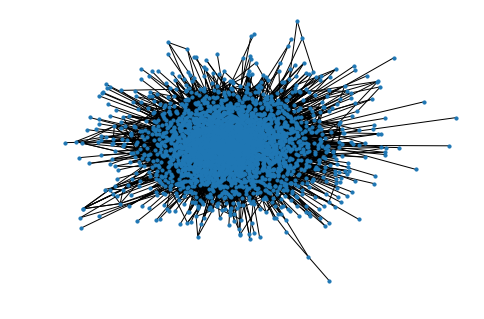

In [37]:
nx.draw_spring(test_graphs[0], node_color='C0', node_size=10, figsize=(20,15), dpi=300)
plt.show()

In [47]:
def interactive_graph(graph, name='unamed_plot'):
    plot = Plot(plot_width=800, plot_height=800,
                x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
    plot.title.text = "Graph {}".format(name)
    plot.add_tools(BoxZoomTool(), ResetTool())
    graph_renderer = from_networkx(graph, nx.spring_layout, scale=1, center=(0, 0))
    graph_renderer.node_renderer.glyph = Circle(size=8, fill_color=Spectral4[0])
    graph_renderer.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)
    plot.renderers.append(graph_renderer)
    output_file(name+".html")
    show(plot)

### Adding noise to the feature vectors 

In [23]:
ppi_features = np.load("/home/gear/data/ppi/ppi-feats.npy")

In [24]:
len(ppi_features)

56944

In [25]:
ppi_features.shape

(56944, 50)

The feature vectors are sparse and multi-hot encoded. Looking at the total sparsity and the sparsity for each train/val/test set.

In [26]:
sum(ppi_features)

array([ 417.,  432.,  717., 1627.,  336.,  564.,  322.,  731.,  826.,
        562.,    0., 1602.,  106.,  701.,  323.,  741.,  596.,  712.,
       1142.,  535.,  426., 1173.,  852.,  866.,  548.,  799.,  755.,
        301.,  246.,  424., 1771., 1164., 1405., 1387., 1209., 9002.,
       1432., 1335., 1278., 1087.,  933., 1310., 1411., 1324., 1185.,
       1160., 1349., 1076., 1247., 1233.])

In [27]:
zero_feature_count = 0
for f in ppi_features:
    if sum(f) == 0:
        zero_feature_count += 1
print("Number of nodes with zero features: ", zero_feature_count)

('Number of nodes with zero features: ', 24211)


In [64]:
zero_feats_test_count = 0
zero_feats_val_count = 0
zero_feats_train_count = 0
for i, f in enumerate(ppi_features):
    if sum(f) == 0:
        if G.node[i]['test']:
            zero_feats_test_count += 1
        elif G.node[i]['val']:
            zero_feats_val_count += 1
        else:
            zero_feats_train_count += 1
print("Test, val, train zero features count: ", zero_feats_test_count, zero_feats_val_count, zero_feats_train_count)

Test, val, train zero features count:  2377 2826 19008


In [65]:
test_count = 0
val_count = 0
train_count = 0
for i in G.nodes():
    if G.node[i]['test']:
        test_count += 1
    elif G.node[i]['val']:
        val_count += 1
    else:
        train_count += 1

In [66]:
print("Test, val, train total node count: ", test_count, val_count, train_count)

Test, val, train total node count:  5524 6514 44906


In [67]:
2377 / 5524

0.43030412744388125

In [68]:
2826 / 6514

0.433834817316549

In [69]:
19008 / 44906

0.4232841936489556

The data is pretty evenly splited in term of zero features nodes.

A few functions to corrupt a single 1-d feature array

In [73]:
for (i, j) in np.random.choice([1,2,3,4,5,6,7,8,9,0], size=(5,2), replace=True):
    print(i,j)

2 5
1 8
6 3
6 4
8 1


In [77]:
def random_swap(arr, noise_rate=0.1):
    assert 0.0 <= noise_rate <= 1.0, "Really?"
    n = len(arr)
    count = int(n *noise_rate)
    if n < 2*count:
        rpl = True
    else:
        rpl = False
    swap_pairs = np.random.choice(range(n), size=(count, 2), replace=rpl)
    for (i, j) in swap_pairs:
        t = arr[i]
        arr[i] = arr[j]
        arr[j] = t
    return arr

In [89]:
def gaussian_noise(arr, mean=0.0, std=1.0):
    arr = np.array(arr, dtype=float)
    arr = arr + np.random.normal(mean, std, size=arr.shape)
    return arr

In [101]:
test = np.array([[1,2,3,4,5], [6,7,8,9,0]])

In [100]:
t = lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.5), 1, aa)

In [102]:
t(test)

array([[5, 4, 3, 2, 1],
       [9, 0, 8, 6, 7]])

In [103]:
test

array([[5, 4, 3, 2, 1],
       [9, 0, 8, 6, 7]])

In [93]:
def corrupt_features(path_to_file, noise_func, name):
    org_features = np.load(path_to_file)
    new_features = noise_func(org_features)
    new_name, ext = os.path.splitext(path_to_file)
    new_name = new_name + name + ext
    np.save(new_name, new_features)
    print("Saved new features set at {}".format(new_name))

In [108]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.2), 1, aa),
                 "-random_swap_0.2")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.2.npy


In [109]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.3), 1, aa),
                 "-random_swap_0.3")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.3.npy


In [110]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.35), 1, aa),
                 "-random_swap_0.35")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.35.npy


In [111]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.4), 1, aa),
                 "-random_swap_0.4")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.4.npy


In [112]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.45), 1, aa),
                 "-random_swap_0.45")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.45.npy


In [113]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.5), 1, aa),
                 "-random_swap_0.5")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.5.npy


In [114]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.55), 1, aa),
                 "-random_swap_0.55")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.55.npy


In [115]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.6), 1, aa),
                 "-random_swap_0.6")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.6.npy


In [116]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.65), 1, aa),
                 "-random_swap_0.65")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.65.npy


In [117]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.7), 1, aa),
                 "-random_swap_0.7")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.7.npy


In [121]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.25), 1, aa),
                 "-random_swap_0.25")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.25.npy


In [122]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.15), 1, aa),
                 "-random_swap_0.15")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.15.npy


In [123]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.1), 1, aa),
                 "-random_swap_0.1")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.1.npy


In [124]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.75), 1, aa),
                 "-random_swap_0.75")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.75.npy


In [125]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.8), 1, aa),
                 "-random_swap_0.8")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.8.npy


In [126]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.85), 1, aa),
                 "-random_swap_0.85")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.85.npy


In [127]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.9), 1, aa),
                 "-random_swap_0.9")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.9.npy


In [128]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=0.95), 1, aa),
                 "-random_swap_0.95")

Saved new features set at /home/gear/data/ppi/ppi-feats-random_swap_0.95.npy


In [129]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: gaussian_noise(a, std=0.01), 1, aa),
                 "-gaussian0_0.01")

Saved new features set at /home/gear/data/ppi/ppi-feats-gaussian0_0.01.npy


In [130]:
corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: gaussian_noise(a, std=0.01), 1, aa),
                 "-gaussian0_0.05")

Saved new features set at /home/gear/data/ppi/ppi-feats-gaussian0_0.05.npy


In [140]:
for i in np.linspace(0.1, 0.95, 18):
    corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: gaussian_noise(a, std=0.01), 1, aa),
                 "-gaussian0_{}".format(i))

Saved new features set at /home/gear/data/ppi/ppi-feats-gaussian0_0.1.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-gaussian0_0.15.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-gaussian0_0.2.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-gaussian0_0.25.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-gaussian0_0.3.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-gaussian0_0.35.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-gaussian0_0.4.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-gaussian0_0.44999999999999996.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-gaussian0_0.5.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-gaussian0_0.5499999999999999.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-gaussian0_0.6.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-gaussian0_0.6499999999999999.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-gaussia

Make a completely random feature set

In [29]:
gaussian_feats = np.random.normal(0,1.0,size=(ppi_features.shape))

In [31]:
np.save("/home/gear/data/ppi/ppi-feats-gaussian.npy", gaussian_feats)

In [43]:
class_map = json.load(open("/home/gear/data/ppi/ppi-class_map.json"))

In [44]:
len(class_map.values()[0])

121

In [48]:
class_map = {int(k):np.array(v) for k,v in class_map.items()}

In [49]:
len(class_map)

56944

This `class_count` should be named `class_1_count`. In the beginning I misunderstood 0 for no label, but it's actually label-0 and label-1.

In [52]:
class_count = sum(i for i in class_map.values())

This array below show how unbalanced each binary category is.

In [81]:
np.asarray(class_count, dtype=float) / len(class_map)

array([0.65253582, 0.24111408, 0.20723869, 0.24411703, 0.12944296,
       0.19385712, 0.24759413, 0.35480472, 0.15460804, 0.34669149,
       0.21754706, 0.23774234, 0.70799382, 0.18818488, 0.18521706,
       0.36959118, 0.10371593, 0.1404889 , 0.26905381, 0.42566381,
       0.19132832, 0.62814344, 0.23066521, 0.32488058, 0.16279151,
       0.6328147 , 0.66825302, 0.33464456, 0.69712349, 0.1774726 ,
       0.68154678, 0.14412405, 0.88820596, 0.16287932, 0.21633535,
       0.32728646, 0.19705325, 0.20992554, 0.41200126, 0.21501826,
       0.14461576, 0.20727381, 0.20567575, 0.20251475, 0.13393861,
       0.28041585, 0.38778449, 0.39542357, 0.24160579, 0.23199986,
       0.35524375, 0.29471059, 0.43430388, 0.41646179, 0.25173855,
       0.26078252, 0.16423153, 0.16691838, 0.169254  , 0.23033155,
       0.45398988, 0.15625878, 0.19187272, 0.21501826, 0.20300646,
       0.12427999, 0.49648778, 0.32970989, 0.47504566, 0.28327831,
       0.24160579, 0.16279151, 0.16393299, 0.29205886, 0.19134

It might be interesting to look into each category to see what's their accuracy scores.

In [82]:
test_node_set = set([i for g in test_graphs for i in g])

In [83]:
val_node_set = set([i for g in val_graphs for i in g])

In [84]:
train_node_set = set([i for g in train_graphs for i in g])

In [89]:
test_node_set.intersection(val_node_set) or train_node_set.intersection(val_node_set) or test_node_set.intersection(train_node_set)

set()

In [97]:
def random_swap(arr, noise_rate=0.1):
    assert 0.0 <= noise_rate <= 1.0, "Really?"
    n = len(arr)
    count = int(n *noise_rate)
    if n < 2*count:
        rpl = True
    else:
        rpl = False
    swap_pairs = np.random.choice(range(n), size=(count, 2), replace=rpl)
    for (i, j) in swap_pairs:
        t = arr[i]
        arr[i] = arr[j]
        arr[j] = t
    return arr

In [139]:
def corrupt_features(path_to_file, noise_func, name, include=None):
    org_features = np.load(path_to_file)
    if include is not None:
        new_features = org_features[list(include)]
    else:
        new_features = org_features
    new_features = noise_func(new_features)
    new_name, ext = os.path.splitext(path_to_file)
    new_name = new_name + name + ext
    if include is not None:
        org_features[list(include)] = new_features
        new_features = org_features
    np.save(new_name, new_features)
    print("Saved new features set at {}".format(new_name))

In [143]:
for i in np.linspace(0.05, 0.95, 19):
    i = np.round(i, 2)
    corrupt_features("/home/gear/data/ppi/ppi-feats.npy", 
                 lambda aa: np.apply_along_axis(lambda a: random_swap(a, noise_rate=i), 1, aa),
                 "-swap_train_{}".format(i), include=train_node_set)

Saved new features set at /home/gear/data/ppi/ppi-feats-swap_train_0.05.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-swap_train_0.1.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-swap_train_0.15.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-swap_train_0.2.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-swap_train_0.25.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-swap_train_0.3.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-swap_train_0.35.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-swap_train_0.4.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-swap_train_0.45.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-swap_train_0.5.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-swap_train_0.55.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-swap_train_0.6.npy
Saved new features set at /home/gear/data/ppi/ppi-feats-swap_train_0.65.npy
Saved new features

In [146]:
np.random.choice(list(train_node_set), 5)

array([ 4240,  4898,  1710, 30480, 24744])

In [150]:
np.random.choice(list(test_node_set), 5)

array([55863, 56038, 56744, 54513, 52126])

In [147]:
features = np.load("/home/gear/data/ppi/ppi-feats.npy")
swap_train_features = np.load("/home/gear/data/ppi/ppi-feats-swap_train_0.35.npy")

In [152]:
all(features[4240] == swap_train_features[4240])

False

In [155]:
all(features[52126] == swap_train_features[52126])

True

In [156]:
G.nodes()[0]

0

In [159]:
G.node[0]

{u'test': False, u'val': False}

## Plot degree histogram for PPI

In [9]:
ppi_degrees = list(G.degree().values())

In [10]:
from matplotlib import rc

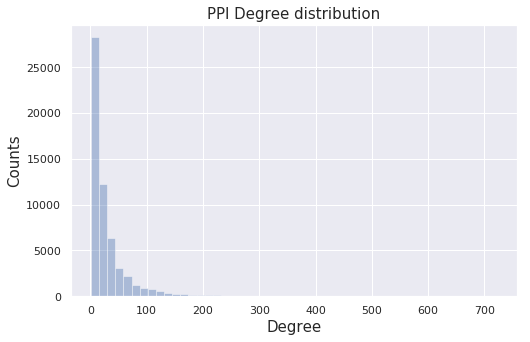

In [31]:
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Computer Modern'})
sns.set_style("white")
sns.set(font_scale=1) 

fig, ax = plt.subplots(figsize=(8,5))
ax.set_title("PPI Degree distribution", fontsize=15)
ax.set_xlabel("Degree", fontsize=15)
ax.set_ylabel("Counts", fontsize=15)
sns.distplot(ppi_degrees, ax=ax, bins=50, kde=False)

plt.savefig("ppi_degree.pdf")

In [32]:
nx.average_clustering(G)

0.1782573484131191

In [33]:
nx.density(G)

0.0005049809080115247

In [35]:
np.mean(ppi_degrees)

28.755127844900255

In [36]:
np.std(ppi_degrees)

39.53299211134761

In [37]:
np.median(ppi_degrees)

16.0

In [17]:
import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh
import sys

def load_data(dataset_str):
    """
    Loads input data from gcn/data directory
    ind.dataset_str.x => the feature vectors of the training instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.tx => the feature vectors of the test instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.allx => the feature vectors of both labeled and unlabeled training instances
        (a superset of ind.dataset_str.x) as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.y => the one-hot labels of the labeled training instances as numpy.ndarray object;
    ind.dataset_str.ty => the one-hot labels of the test instances as numpy.ndarray object;
    ind.dataset_str.ally => the labels for instances in ind.dataset_str.allx as numpy.ndarray object;
    ind.dataset_str.graph => a dict in the format {index: [index_of_neighbor_nodes]} as collections.defaultdict
        object;
    ind.dataset_str.test.index => the indices of test instances in graph, for the inductive setting as list object.
    All objects above must be saved using python pickle module.
    :param dataset_str: Dataset name
    :return: All data input files loaded (as well the training/test data).
    """
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("/data/{}_gcn/ind.{}.{}".format(dataset_str, dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("/data/{}_gcn/ind.{}.test.index".format(dataset_str, dataset_str))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset_str == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    idx_test = test_idx_range.tolist()
    idx_train = range(len(y))
    idx_val = range(len(y), len(y)+500)

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, labels

In [18]:
def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

In [19]:
def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

In [20]:
cora, cora_f, cora_ytrain, cora_yval, cora_ytest, cora_trainm, cora_valm, cora_tmask, cora_l = load_data("cora")

In [23]:
degrees = sum(cora.toarray())

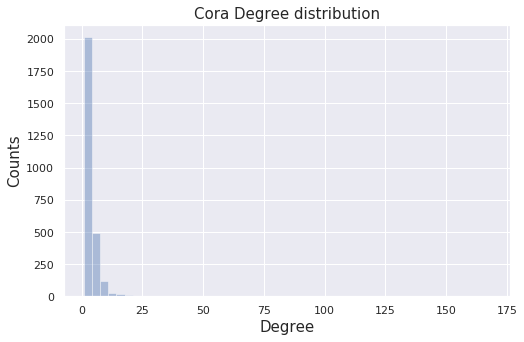

In [25]:
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Computer Modern'})
sns.set_style("white")
sns.set(font_scale=1) 

fig, ax = plt.subplots(figsize=(8,5))
ax.set_title("Cora Degree distribution", fontsize=15)
ax.set_xlabel("Degree", fontsize=15)
ax.set_ylabel("Counts", fontsize=15)
sns.distplot(degrees, ax=ax, bins=50, kde=False)

plt.savefig("cora_degree.pdf")

In [26]:
cora_np = cora.toarray()

In [43]:
cora_dict = {i: np.nonzero(cora_np[i])[0].tolist() for i in range(2708)}

In [81]:
cora_nx = nx.Graph(cora_dict)

**I set node not used for training as validation**

In [82]:
for i, (train, val, test) in enumerate(zip(cora_trainm, cora_valm, cora_tmask)):
    if train:
        cora_nx.node[i][u'test'] = False
        cora_nx.node[i][u'val'] = False
    elif test:
        cora_nx.node[i][u'test'] = True
        cora_nx.node[i][u'val'] = False
    elif val:
        cora_nx.node[i][u'test'] = False
        cora_nx.node[i][u'val'] = True
    else:
        cora_nx.node[i][u'test'] = False
        cora_nx.node[i][u'val'] = False

In [49]:
cora_nx.node[0]

{u'test': False, u'val': False}

In [20]:
cora_f

<2708x1433 sparse matrix of type '<class 'numpy.float32'>'
	with 49216 stored elements in LInked List format>

In [21]:
cora_id = {str(i): i for i in range(2708)}

In [22]:
import json
with open('cora-id_map.json', 'w') as fp:
    json.dump(cora_id, fp)

In [33]:
cora_l

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [46]:
cora_classmap = {str(i): cora_l[i].tolist() for i in range(2708)}

In [47]:
cora_classmap["0"]

[0, 0, 0, 1, 0, 0, 0]

In [48]:
with open('cora-class_map.json', 'w') as fp:
    json.dump(cora_classmap, fp)

In [50]:
np.save("cora-feats.npy", cora_f.toarray())

In [83]:
with open('cora-G.json', 'w') as outfile1:
    outfile1.write(json.dumps(json_graph.node_link_data(cora_nx)))

In [70]:
cora_degrees = [j for i, j in cora_nx.degree()]

In [56]:
cora_data = json.load(open("cora-G.json"))

In [57]:
G = json_graph.node_link_graph(cora_data)

In [58]:
len(G)

2708

In [59]:
G.size()

5278

In [84]:
G.size()

5278

In [61]:
sys.path.append('..')

In [62]:
from graphsage.utils import load_data

In [63]:
train = load_data("/data/cora_gcn/cora", "")

Removed 0 nodes that lacked proper annotations due to networkx versioning issues
Loaded data.. now preprocessing..


In [65]:
cora_nx = train[0]

In [66]:
cora_nx[0]

{633: {'train_removed': True},
 1862: {'train_removed': True},
 2582: {'train_removed': True}}

In [67]:
cora_nx.node[0]

{u'test': False, u'val': False}

In [68]:
cora_nx[633]

{0: {'train_removed': True},
 1701: {'train_removed': True},
 1866: {'train_removed': True}}

In [80]:
cora_nx.edge[1]

{2: {'train_removed': False},
 652: {'train_removed': True},
 654: {'train_removed': True}}